In [27]:
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [5]:
with open('evp/2024-12-20_Viscoplastic_PC1D_process1_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
data['strain'].shape

(1000, 5001, 1)

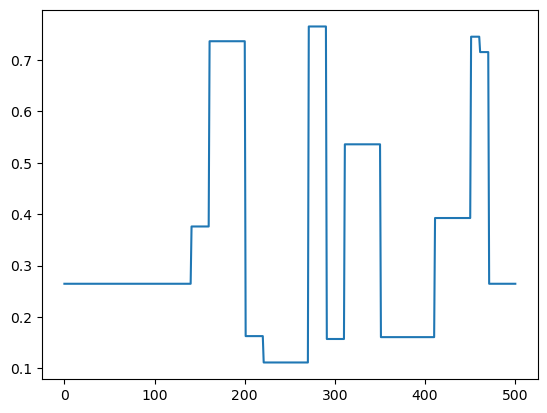

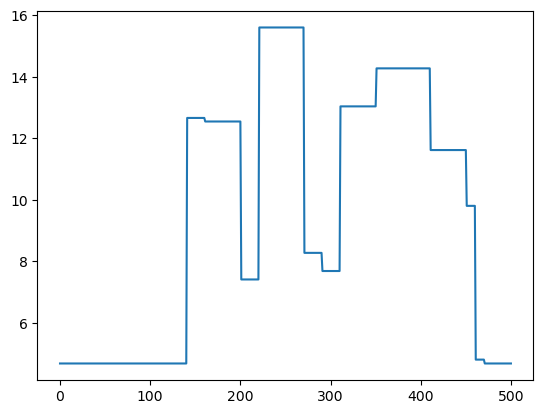

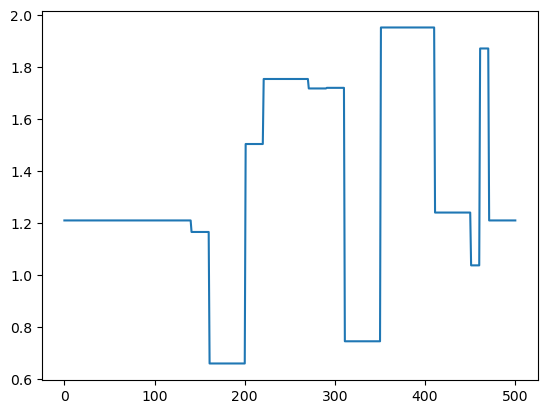

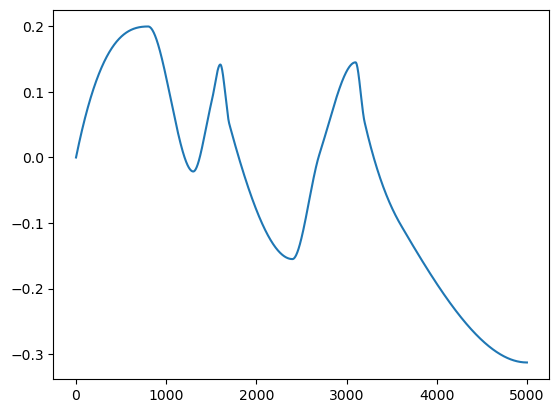

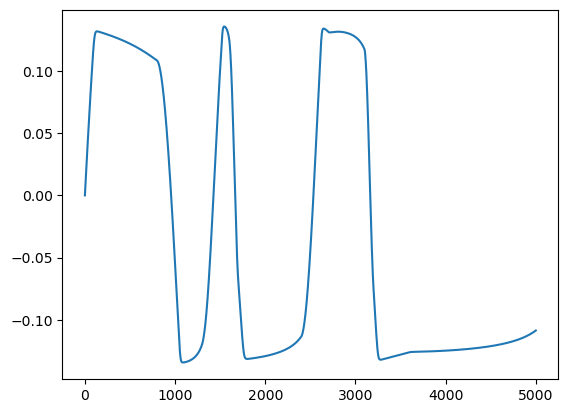

In [24]:
plt.plot(data['yield_stress'][0])
plt.show()
plt.plot(data['rate_exponent'][0])
plt.show()
plt.plot(data['rate_constant'][0])
plt.show()
plt.plot(data['strain'][0])
plt.show()
plt.plot(data['stress'][0])

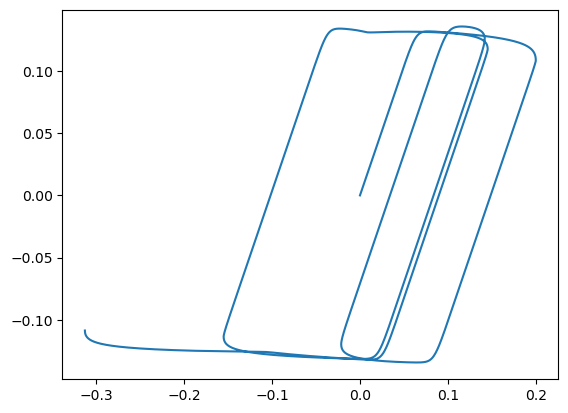

In [26]:
plt.plot(data['strain'][0], data['stress'][0])

In [45]:
E_bar = 1/np.mean(1/data['youngs_modulus'], axis=1, keepdims=True)

In [34]:
s_pred = np.zeros(data['stress'].shape)

In [51]:
xi = np.zeros((1000, 5001, 1))
dt = 1/ 5000
for i in range(data['stress'].shape[1]-1):
    increment = np.mean(E_bar**data['rate_exponent']*data['rate_constant']*np.abs(data['strain'][:,i] - xi[:,i])**data['rate_exponent']*data['yield_stress']**(-data['rate_exponent']), axis=1, keepdims=True)
    xi[:,i+1] = xi[:,i] + dt*np.sign(data['strain'][:,i] - xi[:,i])*increment
    s_pred[:,i+1] = E_bar*(data['strain'][:,i+1] - xi[:,i+1])

In [55]:
error = np.mean((s_pred - data['stress'])**2)


In [56]:
error

8.417327141135792e-07